# Implementation of a KAN for regression
In this notebook I implement a Kolmogorov-Arnold Network (KAN) for the use of regression and compare it against a neural network of a similar architecture.

## Initialisations

In [4]:
!pip install pykan

In [5]:
import torch
from kan import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


## Loading the Dataset

In [6]:
def load_mercedes_dataset():
    # Load dataset from CSV file
    train_data = pd.read_csv('C:\\Users\Admin\\Documents\\DL_course_project\\default_csv_files\\train.csv')
    test_data = pd.read_csv('C:\\Users\Admin\\Documents\\DL_course_project\\default_csv_files\\test.csv')
    
    # Identify categorical columns
    categorical_cols = train_data.select_dtypes(include=['object']).columns
    
    # Apply one-hot encoding to categorical columns
    encoder = OneHotEncoder(drop='first', sparse=False)
    train_encoded = encoder.fit_transform(train_data[categorical_cols])
    test_encoded = encoder.fit_transform(test_data[categorical_cols])
    
    # Drop original categorical columns and concatenate encoded columns
    train_data = train_data.drop(columns=categorical_cols).join(pd.DataFrame(train_encoded, index=train_data.index))
    test_data = test_data.drop(columns=categorical_cols).join(pd.DataFrame(test_encoded, index=test_data.index))
    
    # Separate features and target variable
    X = train_data.drop(columns=['y']).values
    y = train_data['y'].values
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Apply PCA to reduce to 8 dimensions
    pca = PCA(n_components=8)
    X_pca = pca.fit_transform(X)
    
    # Convert to PyTorch tensors
    data_tensor = torch.tensor(X_pca, dtype=torch.float32)
    target_tensor = torch.tensor(y, dtype=torch.float32)
    
    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)
    
    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = DataLoader(TensorDataset(train_data, train_target), batch_size=1, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_data, test_target), batch_size=1, shuffle=False)
    
    # Move data to device and concatenate into a single tensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_inputs = torch.empty(0, train_data.shape[1], device=device)
    train_labels = torch.empty(0, dtype=torch.float32, device=device)
    test_inputs = torch.empty(0, test_data.shape[1], device=device)
    test_labels = torch.empty(0, dtype=torch.float32, device=device)
    
    for data, labels in tqdm(train_loader):
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)
    
    for data, labels in tqdm(test_loader):
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)
    
    dataset = {}
    dataset['train_input'] = train_inputs
    dataset['test_input'] = test_inputs
    dataset['train_label'] = train_labels.reshape(-1, 1)
    dataset['test_label'] = test_labels.reshape(-1, 1)
    
    return dataset

calhous_dataset = load_mercedes_dataset()

<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
C:\Users\Admin\AppData\Local\Temp\ipykernel_7824\3007696550.py:3: SyntaxWarning: invalid escape sequence '\A'
  train_data = pd.read_csv('C:\\Users\Admin\\Documents\\DL_course_project\\default_csv_files\\train.csv')
C:\Users\Admin\AppData\Local\Temp\ipykernel_7824\3007696550.py:4: SyntaxWarning: invalid escape sequence '\A'
  test_data = pd.read_csv('C:\\Users\Admin\\Documents\\DL_course_project\\default_csv_files\\test.csv')
C:\Users\Admin\AppData\Local\Temp\ipykernel_7824\3007696550.py:3: SyntaxWarning: invalid escape sequence '\A'
  train_data = pd.read_csv('C:\\Users\Admin\\Documents\\DL_course_project\\default_csv_files\\train.csv')
C:\Users\Admin\AppData\Local\Temp\ipykernel_7824\3007696550.py:4: SyntaxWarning: invalid escape sequence '\A'
  test_data = pd.read_csv('C:\\Users\Admin\\

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [ ]:
print("Train data shape: {}".format(calhous_dataset['train_input'].shape))
print("Train target shape: {}".format(calhous_dataset['train_label'].shape))
print("Test data shape: {}".format(calhous_dataset['test_input'].shape))
print("Test target shape: {}".format(calhous_dataset['test_label'].shape))


Train data shape: torch.Size([3367, 16])
Train target shape: torch.Size([3367, 1])
Test data shape: torch.Size([842, 16])
Test target shape: torch.Size([842, 1])


## Creating and Training the KAN

In [ ]:
image_folder = 'video_img'

model = KAN(width=[8, 3, 1], grid=10, k=3, seed=0, device=device)

In [ ]:
def train_mse():
    with torch.no_grad():
        predictions = model(calhous_dataset['train_input'])
        mse = torch.nn.functional.mse_loss(predictions, calhous_dataset['train_label'])
    return mse

def test_mse():
    with torch.no_grad():
        predictions = model(calhous_dataset['test_input'])
        mse = torch.nn.functional.mse_loss(predictions, calhous_dataset['test_label'])
    return mse

# Debugging: Print the shape of the tensors
print("Train input shape:", calhous_dataset['train_input'].shape)
print("Train label shape:", calhous_dataset['train_label'].shape)
print("Test input shape:", calhous_dataset['test_input'].shape)
print("Test label shape:", calhous_dataset['test_label'].shape)

# Ensure the model and dataset are on the same device
calhous_dataset['train_input'] = calhous_dataset['train_input'].to(device)
calhous_dataset['train_label'] = calhous_dataset['train_label'].to(device)
calhous_dataset['test_input'] = calhous_dataset['test_input'].to(device)
calhous_dataset['test_label'] = calhous_dataset['test_label'].to(device)
model = model.to(device)

results = model.train(calhous_dataset, opt="LBFGS", device=device, metrics=(train_mse, test_mse),
                      loss_fn=torch.nn.MSELoss(), steps=45, lamb=0.01, lamb_entropy=2., save_fig=True, img_folder=image_folder)


Train input shape: torch.Size([3367, 16])
Train label shape: torch.Size([3367, 1])
Test input shape: torch.Size([842, 16])
Test label shape: torch.Size([842, 1])


description:   0%|                                                           | 0/25 [00:00<?, ?it/s]c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
train loss: 8.99e+00 | test loss: 9.03e+00 | reg: 3.44e+01 :  32%|▉  | 8/25 [04:12<08:34, 30.27s/it]

In [ ]:
print(results['train_mse'][-1], results['test_mse'][-1])

78.08160400390625 86.84236145019531


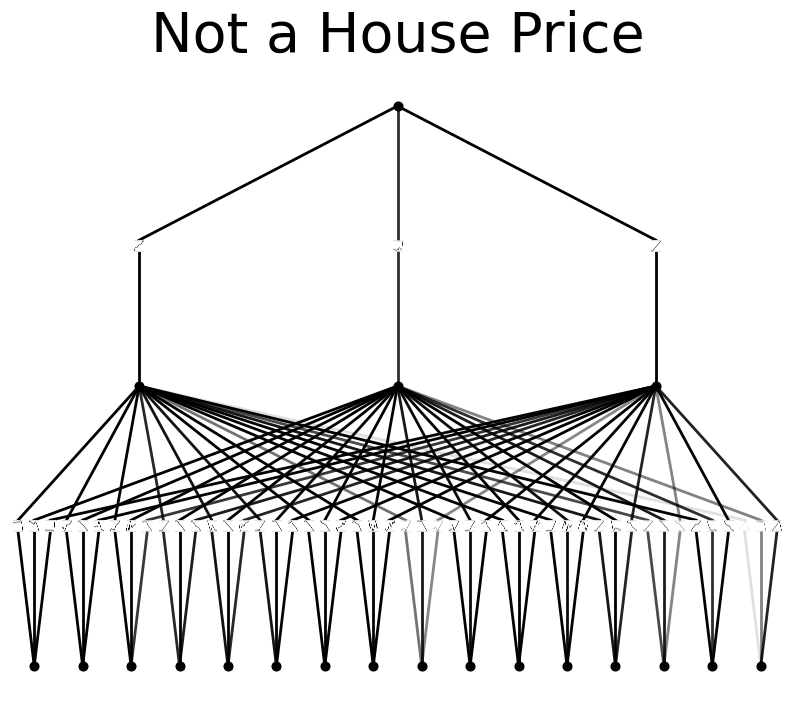

In [ ]:
model.plot(beta=50, scale=1, out_vars=['Time for Greener Manufacturing'])

In [ ]:
import moviepy.video.io.ImageSequenceClip


video_name='video'
fps=10

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


# Implementation of a Neural Network for comparison

## Misc Functions

In [ ]:
class CalHousNet(nn.Module):
    def __init__(self):
        super(CalHousNet, self).__init__()
        self.fc1 = nn.Linear(8, 3)  # 8 inputs to 5 hidden nodes
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(3, 1)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=45):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def test_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            outputs = model(inputs)
            loss = torch.nn.functional.mse_loss(outputs, labels, reduction='sum')
            total_loss += loss.item()
            total_count += labels.size(0)

    # Calculate the average MSE over all batches
    average_mse = total_loss / total_count
    print(f'Mean Squared Error: {average_mse}')

In [ ]:
def load_calhous_dataset():
    # Load dataset from CSV file
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # Identify categorical columns
    categorical_cols = train_data.select_dtypes(include=['object']).columns
    
    # Apply one-hot encoding to categorical columns
    encoder = OneHotEncoder(drop='first', sparse=False)
    train_encoded = encoder.fit_transform(train_data[categorical_cols])
    test_encoded = encoder.fit_transform(test_data[categorical_cols])
    
    # Drop original categorical columns and concatenate encoded columns
    train_data = train_data.drop(columns=categorical_cols).join(pd.DataFrame(train_encoded, index=train_data.index))
    test_data = test_data.drop(columns=categorical_cols).join(pd.DataFrame(test_encoded, index=test_data.index))
    
    # Separate features and target variable
    X = train_data.drop(columns=['y']).values
    y = train_data['y'].values
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Apply PCA to reduce to 8 dimensions
    pca = PCA(n_components=8)
    X_pca = pca.fit_transform(X)
    
    # Convert to PyTorch tensors
    data_tensor = torch.tensor(X_pca, dtype=torch.float32)
    target_tensor = torch.tensor(y, dtype=torch.float32)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=256, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=256, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_calhous_dataset()

In [ ]:
train_loader = DataLoader(TensorDataset(calhous_dataset['train_input'], calhous_dataset['train_label']), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(calhous_dataset['test_input'], calhous_dataset['test_label']), batch_size=256, shuffle=False)


# Get a batch from train_loader and test_loader
dataiter = iter(train_loader)
data, labels = next(dataiter)
print("Train data shape: {}".format(data.shape))
print("Train target shape: {}".format(labels.shape))

dataiter = iter(test_loader)
data, labels = next(dataiter)
print("Test data shape: {}".format(data.shape))
print("Test target shape: {}".format(labels.shape))
print("====================================")


Train data shape: torch.Size([256, 16])
Train target shape: torch.Size([256, 1])
Test data shape: torch.Size([256, 16])
Test target shape: torch.Size([256, 1])


## Train and Evaluate the NN

In [ ]:
model = CalHousNet().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

train_model(model, train_loader, criterion, optimizer)

Epoch 1, Loss: 7768.1826171875
Epoch 2, Loss: 4465.40673828125
Epoch 3, Loss: 2766.28173828125
Epoch 4, Loss: 3060.652099609375
Epoch 5, Loss: 1766.784423828125
Epoch 6, Loss: 653.1343383789062
Epoch 7, Loss: 871.8079223632812
Epoch 8, Loss: 513.2881469726562
Epoch 9, Loss: 511.07177734375
Epoch 10, Loss: 348.425537109375
Epoch 11, Loss: 316.82916259765625
Epoch 12, Loss: 446.3644714355469
Epoch 13, Loss: 327.8184509277344
Epoch 14, Loss: 507.9695129394531
Epoch 15, Loss: 260.3928527832031
Epoch 16, Loss: 1162.21630859375
Epoch 17, Loss: 137.46975708007812
Epoch 18, Loss: 274.0611877441406
Epoch 19, Loss: 155.44635009765625
Epoch 20, Loss: 725.1028442382812
Epoch 21, Loss: 249.2227325439453
Epoch 22, Loss: 231.14390563964844
Epoch 23, Loss: 166.72982788085938
Epoch 24, Loss: 404.3177490234375
Epoch 25, Loss: 126.91771697998047


In [ ]:
test_model(model, test_loader)

Mean Squared Error: 249.21400404542754
